#### Load in necessary libraries

In [3]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.base import BaseEstimator

In [4]:
# Load in utils file
sys.path.append("/uufs/chpc.utah.edu/common/home/u0914269/clement/projects/20230828_tcga_methylation/side_projects/20232110_TCGA_METHYLATION_CLINICAL_ML/analysis/utils")
from utils import *

In [5]:
# Load in the cleaned tumor / normal data
X, y = get_tumor_normal_ml_data()

In [6]:
# Inspecting the dimensions of the data
X.shape, y.shape

((2733, 275098), (2733,))

**Removing rows with too many NaN values**

In [7]:
# Removing features where half or more values are NaN
columns_to_drop = np.where(X.isna().sum() >= (0.5 * len(X)))[0]
X_filtered = X.drop(X.columns[columns_to_drop], axis = 1)

# Inspecting the dimensions of the data
len(columns_to_drop), X_filtered.shape

(38043, (2733, 237055))

### Defining the pipeline

In [8]:
# Gradient Boosting Model pipeline
gbm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values using the median
    ('pca', PCA(n_components=1000)),  # PCA with 1000 components
    ('gbm', GradientBoostingClassifier(random_state=42))  # Gradient Boosting Model
])


**Setup Optuna for hyperpameter training**

In [9]:
# Define the objective function for Optuna
def optuna_training(trial):
    print(f"Starting trial number: {trial.number}")
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('gbm__n_estimators', 50, 200)
    learning_rate = trial.suggest_float('gbm__learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('gbm__max_depth', 3, 10)
    min_samples_split = trial.suggest_int('gbm__min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('gbm__min_samples_leaf', 1, 20)
    
    # Set the hyperparameters in the pipeline
    gbm_pipeline.set_params(
        gbm__n_estimators=n_estimators,
        gbm__learning_rate=learning_rate,
        gbm__max_depth=max_depth,
        gbm__min_samples_split=min_samples_split,
        gbm__min_samples_leaf=min_samples_leaf
    )
    
    # Perform cross-validation
    scores = cross_val_score(gbm_pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs = 5)
    
    # Return the mean accuracy
    return scores.mean()


In [10]:
# Setting up training / test sets
X_train, X_test, y_train, y_test = stratified_train_test_split(X_filtered, y)

# Inspect the shape of the train test split
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2186, 237055), (547, 237055), (2186,), (547,))

In [11]:
# Checking data type
type(X_train), type(y_train), type(X_test), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series)

In [12]:
# Converting data to numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

type(X_train), type(y_train), type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [37]:
# Conduncting the Optuna run
study = optuna.create_study(direction='maximize')
study.optimize(optuna_training, n_trials=50)

print(f"Chosen hyperparameters: {study.best_params}")

[I 2024-12-01 23:50:59,387] A new study created in memory with name: no-name-1a10ea96-7489-48e4-a235-ae199e1d0c73


Starting trial number: 0


[I 2024-12-01 23:57:23,311] Trial 0 finished with value: 0.9725515396591538 and parameters: {'gbm__n_estimators': 166, 'gbm__learning_rate': 0.011889696892992931, 'gbm__max_depth': 5, 'gbm__min_samples_split': 10, 'gbm__min_samples_leaf': 20}. Best is trial 0 with value: 0.9725515396591538.


Starting trial number: 1


[I 2024-12-02 00:05:37,679] Trial 1 finished with value: 0.9807863912312049 and parameters: {'gbm__n_estimators': 148, 'gbm__learning_rate': 0.11641758164469138, 'gbm__max_depth': 9, 'gbm__min_samples_split': 15, 'gbm__min_samples_leaf': 14}. Best is trial 1 with value: 0.9807863912312049.


Starting trial number: 2


[I 2024-12-02 00:13:56,247] Trial 2 finished with value: 0.9803297702266386 and parameters: {'gbm__n_estimators': 169, 'gbm__learning_rate': 0.17002925312514963, 'gbm__max_depth': 9, 'gbm__min_samples_split': 13, 'gbm__min_samples_leaf': 9}. Best is trial 1 with value: 0.9807863912312049.


Starting trial number: 3


[I 2024-12-02 00:19:09,354] Trial 3 finished with value: 0.9739245373708243 and parameters: {'gbm__n_estimators': 57, 'gbm__learning_rate': 0.12788887268324062, 'gbm__max_depth': 9, 'gbm__min_samples_split': 10, 'gbm__min_samples_leaf': 3}. Best is trial 1 with value: 0.9807863912312049.


Starting trial number: 4


[I 2024-12-02 00:26:30,107] Trial 4 finished with value: 0.9711774970481596 and parameters: {'gbm__n_estimators': 168, 'gbm__learning_rate': 0.15264217301199745, 'gbm__max_depth': 10, 'gbm__min_samples_split': 11, 'gbm__min_samples_leaf': 1}. Best is trial 1 with value: 0.9807863912312049.


Starting trial number: 5


[I 2024-12-02 00:30:28,397] Trial 5 finished with value: 0.9798721043227486 and parameters: {'gbm__n_estimators': 66, 'gbm__learning_rate': 0.2395282627623239, 'gbm__max_depth': 3, 'gbm__min_samples_split': 14, 'gbm__min_samples_leaf': 1}. Best is trial 1 with value: 0.9807863912312049.


Starting trial number: 6


[I 2024-12-02 00:36:28,696] Trial 6 finished with value: 0.9757541560870611 and parameters: {'gbm__n_estimators': 143, 'gbm__learning_rate': 0.02540365215399748, 'gbm__max_depth': 5, 'gbm__min_samples_split': 15, 'gbm__min_samples_leaf': 3}. Best is trial 1 with value: 0.9807863912312049.


Starting trial number: 7


[I 2024-12-02 00:42:05,341] Trial 7 finished with value: 0.9807874361305288 and parameters: {'gbm__n_estimators': 83, 'gbm__learning_rate': 0.13851077828115166, 'gbm__max_depth': 8, 'gbm__min_samples_split': 17, 'gbm__min_samples_leaf': 14}. Best is trial 7 with value: 0.9807874361305288.


Starting trial number: 8


[I 2024-12-02 00:50:30,876] Trial 8 finished with value: 0.9821583440435514 and parameters: {'gbm__n_estimators': 133, 'gbm__learning_rate': 0.1433469779559018, 'gbm__max_depth': 10, 'gbm__min_samples_split': 8, 'gbm__min_samples_leaf': 3}. Best is trial 8 with value: 0.9821583440435514.


Starting trial number: 9


[I 2024-12-02 00:56:27,194] Trial 9 finished with value: 0.9826170548467654 and parameters: {'gbm__n_estimators': 165, 'gbm__learning_rate': 0.26925119160318367, 'gbm__max_depth': 4, 'gbm__min_samples_split': 15, 'gbm__min_samples_leaf': 18}. Best is trial 9 with value: 0.9826170548467654.


Starting trial number: 10


[I 2024-12-02 01:02:07,277] Trial 10 finished with value: 0.9817027679383091 and parameters: {'gbm__n_estimators': 194, 'gbm__learning_rate': 0.28919733500016004, 'gbm__max_depth': 3, 'gbm__min_samples_split': 2, 'gbm__min_samples_leaf': 20}. Best is trial 9 with value: 0.9826170548467654.


Starting trial number: 11


[I 2024-12-02 01:07:55,724] Trial 11 finished with value: 0.981246146933743 and parameters: {'gbm__n_estimators': 108, 'gbm__learning_rate': 0.22199617409780692, 'gbm__max_depth': 6, 'gbm__min_samples_split': 6, 'gbm__min_samples_leaf': 7}. Best is trial 9 with value: 0.9826170548467654.


Starting trial number: 12


[I 2024-12-02 01:14:24,206] Trial 12 finished with value: 0.9807863912312049 and parameters: {'gbm__n_estimators': 121, 'gbm__learning_rate': 0.08011563307115352, 'gbm__max_depth': 7, 'gbm__min_samples_split': 20, 'gbm__min_samples_leaf': 14}. Best is trial 9 with value: 0.9826170548467654.


Starting trial number: 13


[I 2024-12-02 01:20:39,938] Trial 13 finished with value: 0.9830747207506556 and parameters: {'gbm__n_estimators': 194, 'gbm__learning_rate': 0.19731084853607964, 'gbm__max_depth': 4, 'gbm__min_samples_split': 6, 'gbm__min_samples_leaf': 17}. Best is trial 13 with value: 0.9830747207506556.


Starting trial number: 14


[I 2024-12-02 01:26:23,471] Trial 14 finished with value: 0.9849043394668925 and parameters: {'gbm__n_estimators': 193, 'gbm__learning_rate': 0.2887303747673975, 'gbm__max_depth': 4, 'gbm__min_samples_split': 4, 'gbm__min_samples_leaf': 17}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 15


[I 2024-12-02 01:32:57,076] Trial 15 finished with value: 0.9826160099474416 and parameters: {'gbm__n_estimators': 198, 'gbm__learning_rate': 0.2044593773472988, 'gbm__max_depth': 4, 'gbm__min_samples_split': 3, 'gbm__min_samples_leaf': 16}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 16


[I 2024-12-02 01:38:33,678] Trial 16 finished with value: 0.9807874361305288 and parameters: {'gbm__n_estimators': 185, 'gbm__learning_rate': 0.256697370786256, 'gbm__max_depth': 6, 'gbm__min_samples_split': 5, 'gbm__min_samples_leaf': 12}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 17


[I 2024-12-02 01:44:48,599] Trial 17 finished with value: 0.9844477184623261 and parameters: {'gbm__n_estimators': 182, 'gbm__learning_rate': 0.19164907993671204, 'gbm__max_depth': 4, 'gbm__min_samples_split': 6, 'gbm__min_samples_leaf': 17}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 18


[I 2024-12-02 01:50:01,126] Trial 18 finished with value: 0.9830747207506556 and parameters: {'gbm__n_estimators': 102, 'gbm__learning_rate': 0.2955366439422459, 'gbm__max_depth': 5, 'gbm__min_samples_split': 4, 'gbm__min_samples_leaf': 11}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 19


[I 2024-12-02 01:55:29,754] Trial 19 finished with value: 0.9835334315538699 and parameters: {'gbm__n_estimators': 184, 'gbm__learning_rate': 0.08894343577094205, 'gbm__max_depth': 3, 'gbm__min_samples_split': 8, 'gbm__min_samples_leaf': 8}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 20


[I 2024-12-02 02:02:50,292] Trial 20 finished with value: 0.9807874361305288 and parameters: {'gbm__n_estimators': 152, 'gbm__learning_rate': 0.18446524964401956, 'gbm__max_depth': 7, 'gbm__min_samples_split': 8, 'gbm__min_samples_leaf': 18}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 21


[I 2024-12-02 02:08:10,347] Trial 21 finished with value: 0.9826170548467654 and parameters: {'gbm__n_estimators': 180, 'gbm__learning_rate': 0.07988998383571075, 'gbm__max_depth': 3, 'gbm__min_samples_split': 8, 'gbm__min_samples_leaf': 8}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 22


[I 2024-12-02 02:14:18,471] Trial 22 finished with value: 0.9830736758513318 and parameters: {'gbm__n_estimators': 181, 'gbm__learning_rate': 0.09161955853236511, 'gbm__max_depth': 4, 'gbm__min_samples_split': 7, 'gbm__min_samples_leaf': 6}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 23


[I 2024-12-02 02:19:36,129] Trial 23 finished with value: 0.9798721043227484 and parameters: {'gbm__n_estimators': 181, 'gbm__learning_rate': 0.04238872552234543, 'gbm__max_depth': 3, 'gbm__min_samples_split': 4, 'gbm__min_samples_leaf': 12}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 24


[I 2024-12-02 02:25:58,124] Trial 24 finished with value: 0.9826170548467654 and parameters: {'gbm__n_estimators': 158, 'gbm__learning_rate': 0.055450016663690566, 'gbm__max_depth': 5, 'gbm__min_samples_split': 2, 'gbm__min_samples_leaf': 16}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 25


[I 2024-12-02 02:31:24,790] Trial 25 finished with value: 0.9830757656499797 and parameters: {'gbm__n_estimators': 135, 'gbm__learning_rate': 0.2303853649429717, 'gbm__max_depth': 4, 'gbm__min_samples_split': 9, 'gbm__min_samples_leaf': 10}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 26


[I 2024-12-02 02:37:09,800] Trial 26 finished with value: 0.981245102034419 and parameters: {'gbm__n_estimators': 200, 'gbm__learning_rate': 0.11840823247336048, 'gbm__max_depth': 3, 'gbm__min_samples_split': 5, 'gbm__min_samples_leaf': 6}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 27


[I 2024-12-02 02:44:48,234] Trial 27 finished with value: 0.9835323866545458 and parameters: {'gbm__n_estimators': 185, 'gbm__learning_rate': 0.10197285249994295, 'gbm__max_depth': 6, 'gbm__min_samples_split': 12, 'gbm__min_samples_leaf': 19}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 28


[I 2024-12-02 02:50:47,113] Trial 28 finished with value: 0.9826170548467654 and parameters: {'gbm__n_estimators': 174, 'gbm__learning_rate': 0.17111417242114008, 'gbm__max_depth': 4, 'gbm__min_samples_split': 6, 'gbm__min_samples_leaf': 15}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 29


[I 2024-12-02 02:57:13,079] Trial 29 finished with value: 0.9725504947598299 and parameters: {'gbm__n_estimators': 161, 'gbm__learning_rate': 0.010547957870760405, 'gbm__max_depth': 5, 'gbm__min_samples_split': 10, 'gbm__min_samples_leaf': 12}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 30


[I 2024-12-02 03:04:08,730] Trial 30 finished with value: 0.9817017230389853 and parameters: {'gbm__n_estimators': 190, 'gbm__learning_rate': 0.05717834388343265, 'gbm__max_depth': 5, 'gbm__min_samples_split': 4, 'gbm__min_samples_leaf': 20}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 31


[I 2024-12-02 03:11:28,224] Trial 31 finished with value: 0.9807863912312047 and parameters: {'gbm__n_estimators': 173, 'gbm__learning_rate': 0.10200195454303097, 'gbm__max_depth': 6, 'gbm__min_samples_split': 12, 'gbm__min_samples_leaf': 18}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 32


[I 2024-12-02 03:16:59,590] Trial 32 finished with value: 0.9817017230389853 and parameters: {'gbm__n_estimators': 187, 'gbm__learning_rate': 0.10153114399279628, 'gbm__max_depth': 3, 'gbm__min_samples_split': 11, 'gbm__min_samples_leaf': 19}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 33


[I 2024-12-02 03:24:18,719] Trial 33 finished with value: 0.981243012235771 and parameters: {'gbm__n_estimators': 155, 'gbm__learning_rate': 0.07587729316872825, 'gbm__max_depth': 7, 'gbm__min_samples_split': 7, 'gbm__min_samples_leaf': 19}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 34


[I 2024-12-02 03:32:58,378] Trial 34 finished with value: 0.9821604338421993 and parameters: {'gbm__n_estimators': 174, 'gbm__learning_rate': 0.16221745288050016, 'gbm__max_depth': 8, 'gbm__min_samples_split': 9, 'gbm__min_samples_leaf': 16}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 35


[I 2024-12-02 03:39:17,031] Trial 35 finished with value: 0.981245102034419 and parameters: {'gbm__n_estimators': 188, 'gbm__learning_rate': 0.12416375013984621, 'gbm__max_depth': 4, 'gbm__min_samples_split': 13, 'gbm__min_samples_leaf': 9}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 36


[I 2024-12-02 03:45:02,731] Trial 36 finished with value: 0.9821593889428752 and parameters: {'gbm__n_estimators': 146, 'gbm__learning_rate': 0.27276282373579436, 'gbm__max_depth': 6, 'gbm__min_samples_split': 17, 'gbm__min_samples_leaf': 14}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 37


[I 2024-12-02 03:50:20,705] Trial 37 finished with value: 0.9821583440435514 and parameters: {'gbm__n_estimators': 167, 'gbm__learning_rate': 0.21247317482219874, 'gbm__max_depth': 3, 'gbm__min_samples_split': 10, 'gbm__min_samples_leaf': 17}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 38


[I 2024-12-02 03:57:04,124] Trial 38 finished with value: 0.9812440571350951 and parameters: {'gbm__n_estimators': 173, 'gbm__learning_rate': 0.18776541704522726, 'gbm__max_depth': 5, 'gbm__min_samples_split': 13, 'gbm__min_samples_leaf': 13}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 39


[I 2024-12-02 04:03:09,196] Trial 39 finished with value: 0.9784991066110781 and parameters: {'gbm__n_estimators': 199, 'gbm__learning_rate': 0.2434058396831681, 'gbm__max_depth': 8, 'gbm__min_samples_split': 12, 'gbm__min_samples_leaf': 4}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 40


[I 2024-12-02 04:07:30,184] Trial 40 finished with value: 0.9707229658422409 and parameters: {'gbm__n_estimators': 76, 'gbm__learning_rate': 0.02906842752247296, 'gbm__max_depth': 4, 'gbm__min_samples_split': 7, 'gbm__min_samples_leaf': 15}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 41


[I 2024-12-02 04:12:57,492] Trial 41 finished with value: 0.9812440571350949 and parameters: {'gbm__n_estimators': 139, 'gbm__learning_rate': 0.2301104315637979, 'gbm__max_depth': 4, 'gbm__min_samples_split': 9, 'gbm__min_samples_leaf': 10}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 42


[I 2024-12-02 04:17:41,258] Trial 42 finished with value: 0.9826170548467654 and parameters: {'gbm__n_estimators': 124, 'gbm__learning_rate': 0.1502898797195437, 'gbm__max_depth': 3, 'gbm__min_samples_split': 9, 'gbm__min_samples_leaf': 10}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 43


[I 2024-12-02 04:22:44,043] Trial 43 finished with value: 0.9789567725149683 and parameters: {'gbm__n_estimators': 93, 'gbm__learning_rate': 0.2786538129522732, 'gbm__max_depth': 5, 'gbm__min_samples_split': 5, 'gbm__min_samples_leaf': 8}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 44


[I 2024-12-02 04:28:06,347] Trial 44 finished with value: 0.9817017230389851 and parameters: {'gbm__n_estimators': 133, 'gbm__learning_rate': 0.23182804929797796, 'gbm__max_depth': 4, 'gbm__min_samples_split': 11, 'gbm__min_samples_leaf': 9}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 45


[I 2024-12-02 04:32:37,752] Trial 45 finished with value: 0.9807905708285007 and parameters: {'gbm__n_estimators': 115, 'gbm__learning_rate': 0.24993952580850617, 'gbm__max_depth': 3, 'gbm__min_samples_split': 3, 'gbm__min_samples_leaf': 17}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 46


[I 2024-12-02 04:40:44,515] Trial 46 finished with value: 0.9812440571350951 and parameters: {'gbm__n_estimators': 164, 'gbm__learning_rate': 0.2597566336473671, 'gbm__max_depth': 9, 'gbm__min_samples_split': 8, 'gbm__min_samples_leaf': 19}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 47


[I 2024-12-02 04:47:02,898] Trial 47 finished with value: 0.9826149650481175 and parameters: {'gbm__n_estimators': 192, 'gbm__learning_rate': 0.13059450278626325, 'gbm__max_depth': 4, 'gbm__min_samples_split': 6, 'gbm__min_samples_leaf': 5}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 48


[I 2024-12-02 04:53:09,872] Trial 48 finished with value: 0.9817006781396612 and parameters: {'gbm__n_estimators': 179, 'gbm__learning_rate': 0.21650173363053798, 'gbm__max_depth': 5, 'gbm__min_samples_split': 10, 'gbm__min_samples_leaf': 11}. Best is trial 14 with value: 0.9849043394668925.


Starting trial number: 49


[I 2024-12-02 04:59:31,893] Trial 49 finished with value: 0.981245102034419 and parameters: {'gbm__n_estimators': 136, 'gbm__learning_rate': 0.1794901860833903, 'gbm__max_depth': 6, 'gbm__min_samples_split': 7, 'gbm__min_samples_leaf': 8}. Best is trial 14 with value: 0.9849043394668925.


Chosen hyperparameters: {'gbm__n_estimators': 193, 'gbm__learning_rate': 0.2887303747673975, 'gbm__max_depth': 4, 'gbm__min_samples_split': 4, 'gbm__min_samples_leaf': 17}


In [13]:
# Saving the best hyperparameters in a variable for quicker iteration
chosen_params = {'gbm__n_estimators': 193, 'gbm__learning_rate': 0.2887303747673975, 'gbm__max_depth': 4, 'gbm__min_samples_split': 4, 'gbm__min_samples_leaf': 17}


In [14]:
# Training the model with the best parameters found by optuna
#gbm_pipeline.set_params(**chosen_params)
#gbm_pipeline.set_params(**study.best_params)
gbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('pca', PCA(n_components=1000)),
                ('gbm', GradientBoostingClassifier(random_state=42))])

In [16]:
# Evaluate the model on the test set
y_predictions = gbm_pipeline.predict(X_test)
accuracy = gbm_pipeline.score(X_test, y_test)

# Calculate prediction probabilities
y_prediction_probabilities = gbm_pipeline.predict_proba(X_test)[:, 1]

print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.9762340036563071


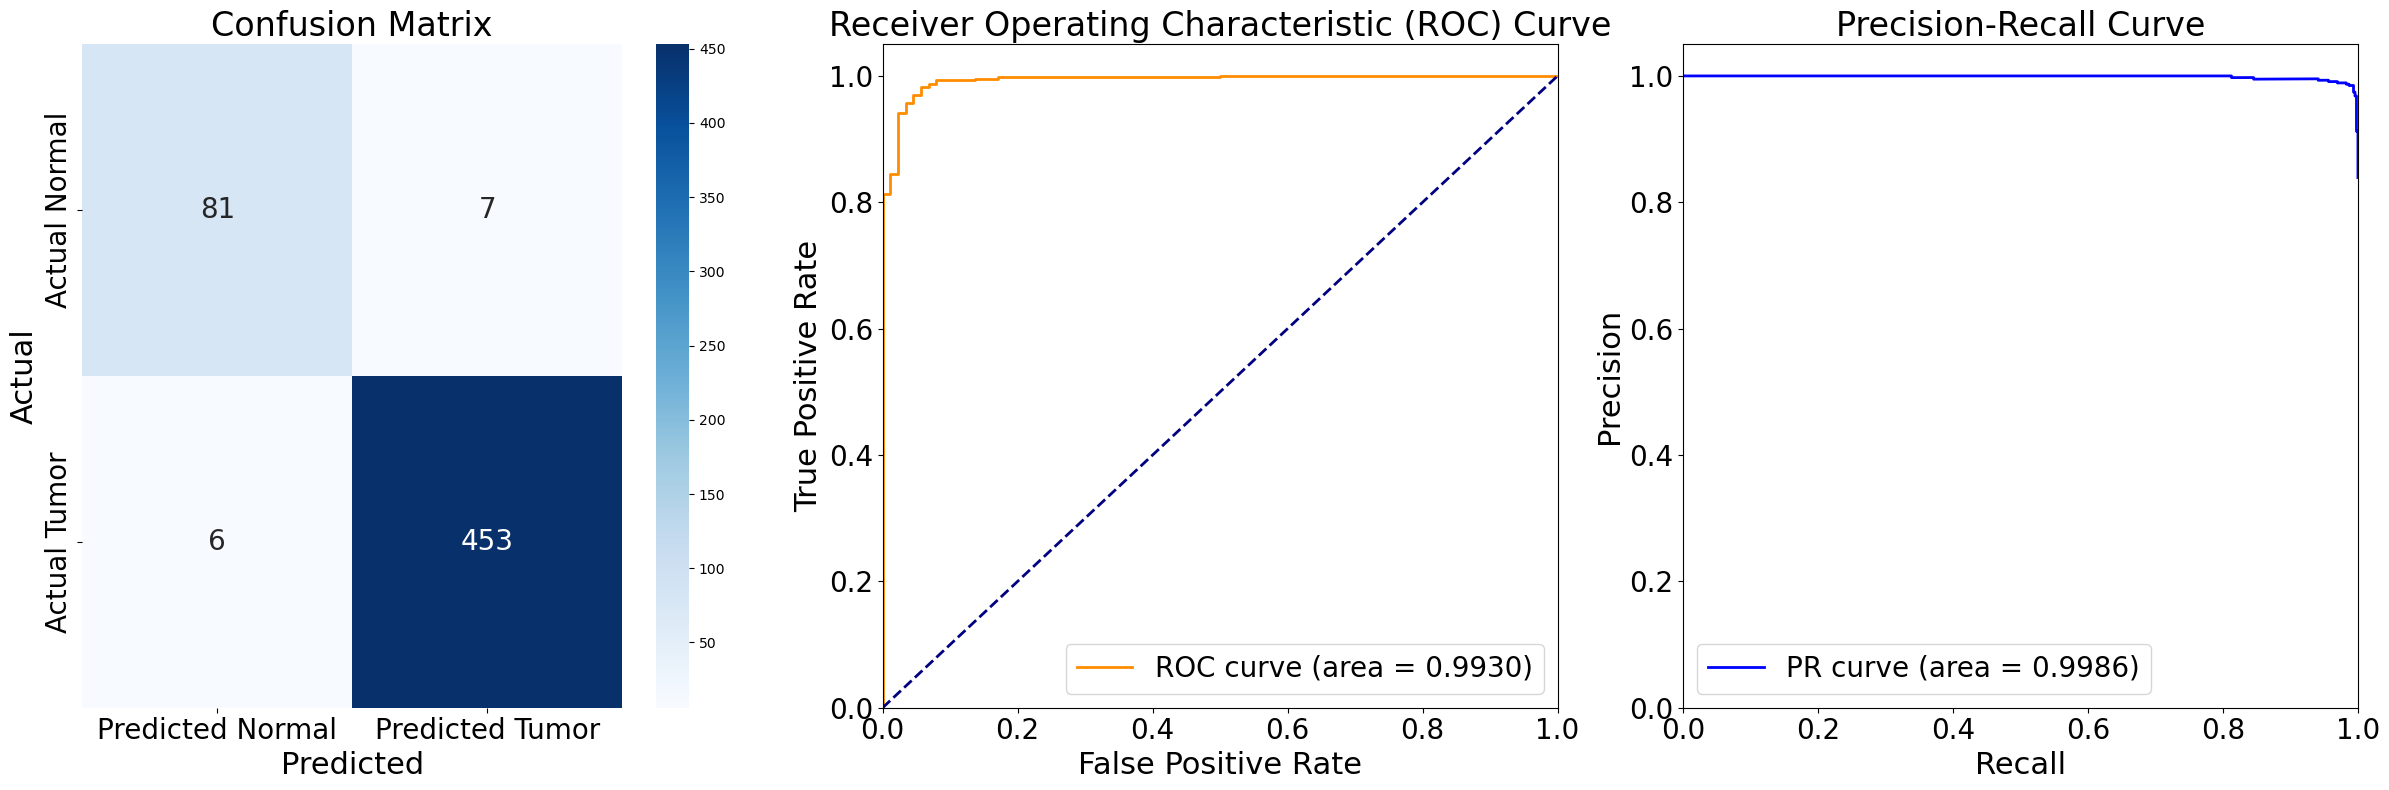

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc

# Assuming y_test are the true labels and y_predictions are the predicted labels
# Assuming y_prediction_probabilities are the predicted probabilities for the positive class

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_predictions)

# Calculate ROC curve and AUC
fpr, tpr, auc_threshold = roc_curve(y_test, y_prediction_probabilities)
roc_auc = roc_auc_score(y_test, y_prediction_probabilities)

# Calculate Precision-Recall curve and AUC
precision, recall, pr_threshold = precision_recall_curve(y_test, y_prediction_probabilities)
pr_auc = auc(recall, precision)

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Tumor'], 
            yticklabels=['Actual Normal', 'Actual Tumor'], 
            ax=axes[0],
            annot_kws={'fontsize': 20})
axes[0].set_xlabel('Predicted', fontsize=22)
axes[0].set_ylabel('Actual', fontsize=22)
axes[0].set_title('Confusion Matrix', fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=20)

# Plot ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=22)
axes[1].set_ylabel('True Positive Rate', fontsize=22)
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=24)
axes[1].legend(loc='lower right', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

# Plot Precision-Recall curve
axes[2].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall', fontsize=22)
axes[2].set_ylabel('Precision', fontsize=22)
axes[2].set_title('Precision-Recall Curve', fontsize=24)
axes[2].legend(loc='lower left', fontsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=20)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("01_gradient_boosting_model_performance.png", dpi=300)

# Show the figure
plt.show()

In [18]:
# Generate a classification report for the model
print(classification_report(y_test, y_predictions, target_names=['Normal', 'Tumor']))

              precision    recall  f1-score   support

      Normal       0.93      0.92      0.93        88
       Tumor       0.98      0.99      0.99       459

    accuracy                           0.98       547
   macro avg       0.96      0.95      0.96       547
weighted avg       0.98      0.98      0.98       547



In [19]:
# Grabbing the pca feature names from the pipeline for use in SHAP
transformed_feature_names = gbm_pipeline[:-1].get_feature_names_out()

In [20]:
# Creating a SHAP explainer that focuses on the gradient boosting model
explainer = shap.Explainer(
    gbm_pipeline.named_steps["gbm"],
    gbm_pipeline[:-1].transform(X_test),
    feature_names=transformed_feature_names,
)
explanations = explainer(gbm_pipeline[:-1].transform(X_test))

In [21]:
# Extracting the loading values from the PCA step of the pipeline
pca_step = gbm_pipeline.named_steps['pca']
pca_loadings = pca_step.components_
pca_loadings_df = pd.DataFrame(pca_loadings, columns=X_filtered.columns, index=[f"PC{i}" for i in range(1, pca_step.n_components_ + 1)])

pca_loadings_df.head()

id,cg21870274,cg08258224,cg16619049,cg18147296,cg13938959,cg12445832,cg23999112,cg11527153,cg27573606,cg04195702,...,cg26348521,cg03370490,cg16974513,cg23628760,cg04920704,cg07236001,cg27267896,cg23079702,cg21073216,cg22820726
PC1,-0.002353,-0.002706,-0.001791,-0.002453,-0.002535,-0.001828,-0.002831,-0.002985,-0.003163,-0.002978,...,-0.002941,-0.003220,-0.003232,-0.003046,-0.002756,-0.002452,-0.003001,-0.002755,-0.002778,-0.002950
PC2,-0.002172,-0.001684,-0.001581,0.001395,-0.002524,-0.002502,-0.001422,-0.000067,0.000551,0.000446,...,-0.000275,0.000175,0.000373,-0.000024,-0.000557,-0.000611,-0.000186,-0.001254,-0.000157,-0.001697
PC3,-0.002748,-0.001244,-0.002506,-0.002243,-0.003804,-0.003900,-0.003188,-0.002040,0.001403,-0.000629,...,0.001027,-0.000058,0.000838,-0.000823,-0.000994,-0.005010,-0.000926,-0.001819,-0.003786,-0.000840
PC4,0.001335,0.002757,-0.001454,0.001964,0.000899,-0.000133,0.001367,0.001767,-0.000096,0.000815,...,0.000589,0.000886,0.000343,0.001180,-0.000846,-0.000622,0.000236,0.002069,0.003431,-0.000373
PC5,0.003740,0.000617,-0.006450,-0.001481,0.000146,-0.003240,0.000204,0.001280,0.000054,0.000316,...,-0.000737,0.000558,0.000216,0.000690,0.001368,0.002809,0.000894,0.000413,0.001866,0.001598


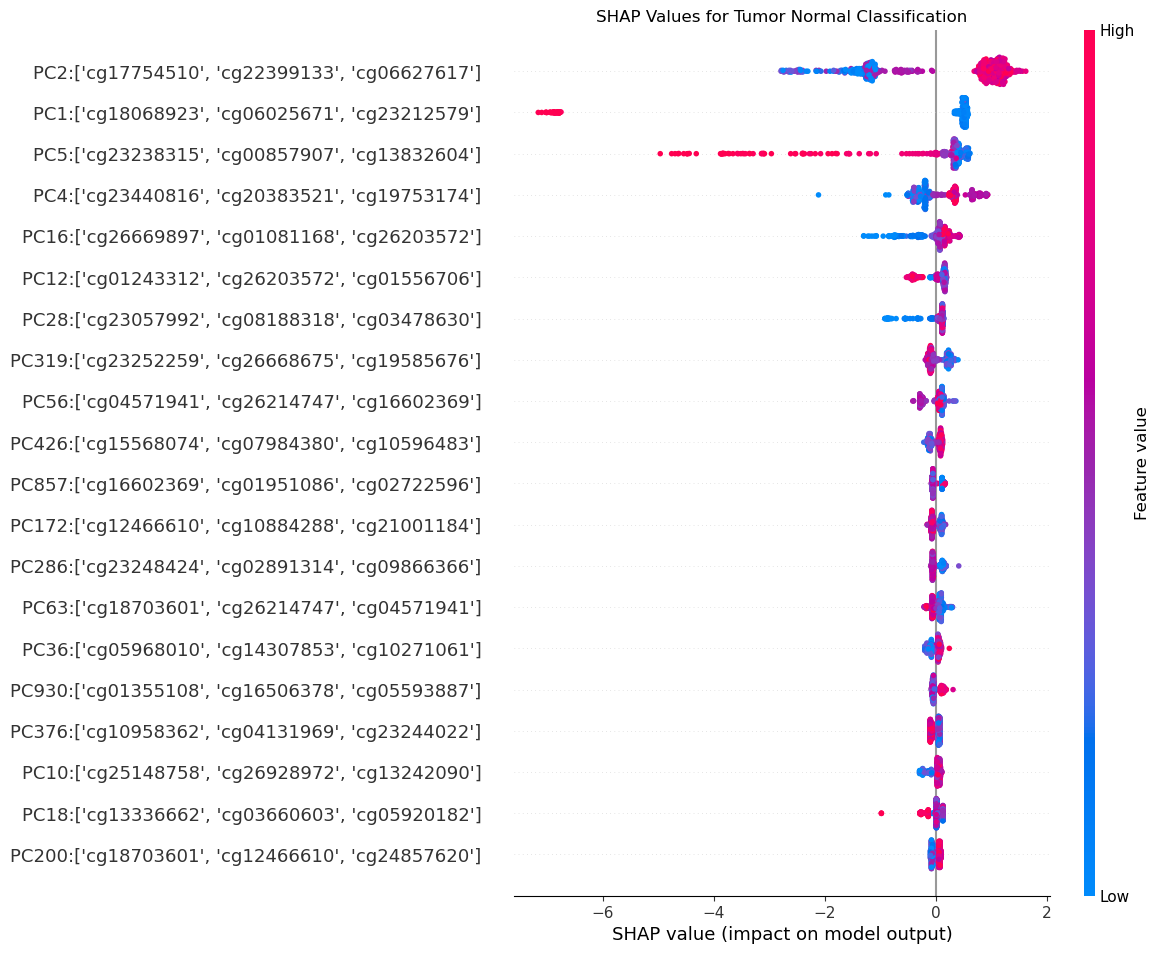

In [22]:
# Generating a Shapley summary plot and replacing the PCA components with the top 3 features
shap_plot_obj = shap.summary_plot(explanations, show = False)

ax = plt.gca()

plotted_components = ax.get_yticklabels()
plotted_components = [label.get_text() for label in plotted_components]

new_labels = []
for component in plotted_components:
    pca_loadings_df.iloc[0,:].abs().sort_values(ascending = False)[:3].index
    formatted_component = component.replace('a', '').upper()
    pc_number = int(formatted_component[2:]) + 1
    formatted_component = f"PC{pc_number}"
    new_labels.append(f"{formatted_component}:{pca_loadings_df.loc[formatted_component,:].abs().sort_values(ascending = False)[:3].index.to_list()}")

ax.set_yticklabels(new_labels)

ax.set_title("SHAP Values for Tumor Normal Classification")

plt.savefig("01_gradient_boosting_shap_summary_plot.png", dpi=300)

plt.show()